In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, BucketIterator
from torchtext import data
from torchtext import vocab

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import pandas as pd

import random
import math
import time
import pickle

from arxiv_title_generation import generate_csv
from arxiv_title_generation import tokenize
from arxiv_title_generation import Encoder, Attention, Decoder, Seq2Seq, init_weights
from arxiv_title_generation import train, evaluate, count_parameters, epoch_time
from arxiv_title_generation import translate_sentence, display_attention

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig

Using TensorFlow backend.


In [2]:
ROOT_PATH = "../../data/raw/title-generation/"

In [3]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
df = pd.read_csv(f"{ROOT_PATH}train.csv")

In [48]:
df.head()

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


In [49]:
src = df["abstract"].values
trg = df["title"].values

In [50]:
trg[:2]

array(['on optimal investment with processes of long or negative memory',
       'boolean complexes for ferrers graphs'], dtype=object)

In [51]:
src = ["[CLS] " + sentence + " [SEP]" for sentence in src]
trg = ["[CLS] " + sentence + " [SEP]" for sentence in trg]

In [52]:
trg[:2]

['[CLS] on optimal investment with processes of long or negative memory [SEP]',
 '[CLS] boolean complexes for ferrers graphs [SEP]']

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [29]:
%%time

tokenized_src = [tokenizer.tokenize(sent) for sent in src]
tokenized_trg = [tokenizer.tokenize(sent) for sent in trg]

CPU times: user 8min 21s, sys: 1.66 s, total: 8min 23s
Wall time: 8min 24s


In [55]:
tokenized_trg = [tokenizer.tokenize(sent) for sent in trg]

In [31]:
tokenized_trg[0]

['[CLS]',
 'on',
 'optimal',
 'investment',
 'with',
 'processes',
 'of',
 'long',
 'or',
 'negative',
 'memory',
 '[SEP]']

In [61]:
tokenizer.save_vocabulary("vocabulary.pkl")

('vocabulary.pkl',)

In [32]:
with open('tokenized_src.pickle', 'wb') as f:
    pickle.dump(tokenized_src, f)

In [56]:
with open('tokenized_trg.pickle', 'wb') as f:
    pickle.dump(tokenized_trg, f)

In [7]:
with open('tokenized_src.pickle', 'rb') as f:
    tokenized_src = pickle.load(f)

In [8]:
with open('tokenized_trg.pickle', 'rb') as f:
    tokenized_trg = pickle.load(f)

In [38]:
lens_src = list(map(len, tokenized_src))

In [39]:
np.mean(lens_src)

191.0014148148148

In [40]:
np.amax(lens_src)

1096

In [57]:
lens_trg = list(map(len, tokenized_trg))

In [58]:
np.mean(lens_trg)

15.854481481481482

In [59]:
np.amax(lens_trg)

103

In [60]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_src]
output_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_trg]

input_ids = pad_sequences(
    input_ids,
    maxlen=1000,
    dtype="long",
    truncating="post",
    padding="post"
)
output_ids = pad_sequences(
    output_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, output_ids, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [16]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [17]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

In [4]:
TEXT = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            include_lengths = True,
            lower = True)

trn_data_fields = [("src", TEXT),
                   ("trg", TEXT)]

dataset = data.TabularDataset(
    path=f"{ROOT_PATH}train.csv",
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [5]:
# python -m gensim.downloader --download glove-wiki-gigaword-300
vec = vocab.Vectors('/home/science/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz')
TEXT.build_vocab(train_data, valid_data, test_data, vectors=vec, min_freq = 7)

In [6]:
print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 40938


In [7]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [8]:
# train_batch_it = BatchGenerator(train_iterator, 'src', 'trg')

In [9]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(TEXT.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = TEXT.vocab.stoi['<pad>']
SOS_IDX = TEXT.vocab.stoi['<sos>']
EOS_IDX = TEXT.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

In [10]:
model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)
model.apply(init_weights)
glove_vectors = TEXT.vocab.vectors
model.encoder.embedding.weight.data.copy_(glove_vectors)
model.decoder.embedding.weight.data.copy_(glove_vectors)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [11]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 45,001,298 trainable parameters


In [32]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [33]:
MODEL_NAME = 'models/lstm_baseline.pt'
N_EPOCHS = 10
CLIP = 1

train_history = []
valid_history = []

best_valid_loss = float('inf')

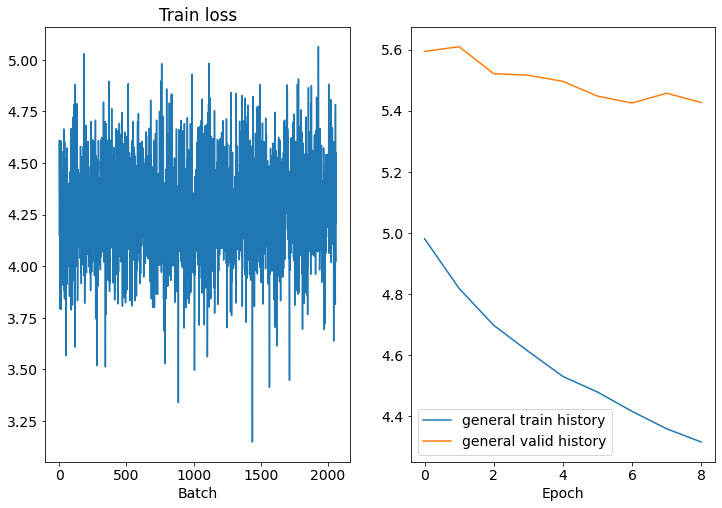

Epoch: 10 | Time: 15m 2s
	Train Loss: 4.276 | Train PPL:  71.917
	 Val. Loss: 5.437 |  Val. PPL: 229.760
CPU times: user 2h 43min 22s, sys: 1h 22min 1s, total: 4h 5min 24s
Wall time: 2h 29min 59s


In [35]:
%%time

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')`

In [36]:
# for cpu usage
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')))

# for gpu usage
# model.load_state_dict(torch.load(MODEL_NAME), map_location=torch.device('cpu'))


test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.488 | Test PPL: 241.831 |


In [37]:
example_idx = 100

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['the', 'integrated', 'completed', 'likelihood', '(', 'icl', ')', 'criterion', 'has', 'proven', 'to', 'be', 'a', 'very', 'popular', 'approach', 'in', 'model', '-', 'based', 'clustering', 'through', 'automatically', 'choosing', 'the', 'number', 'of', 'clusters', 'in', 'a', 'mixture', 'model', '.', 'this', 'approach', 'effectively', 'maximises', 'the', 'complete', 'data', 'likelihood', ',', 'thereby', 'including', 'the', 'allocation', 'of', 'observations', 'to', 'clusters', 'in', 'the', 'model', 'selection', 'criterion', '.', 'however', 'for', 'practical', 'implementation', 'one', 'needs', 'to', 'introduce', 'an', 'approximation', 'in', 'order', 'to', 'estimate', 'the', 'icl', '.', 'our', 'contribution', 'here', 'is', 'to', 'illustrate', 'that', 'through', 'the', 'use', 'of', 'conjugate', 'priors', 'one', 'can', 'derive', 'an', 'exact', 'expression', 'for', 'icl', 'and', 'so', 'avoiding', 'any', 'approximation', '.', 'moreover', ',', 'we', 'illustrate', 'how', 'one', 'can', 'find',

In [38]:
translation, attention = translate_sentence(model, src, TEXT, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', '-', 'based', 'model', 'selection', 'for', 'the', 'clustering']


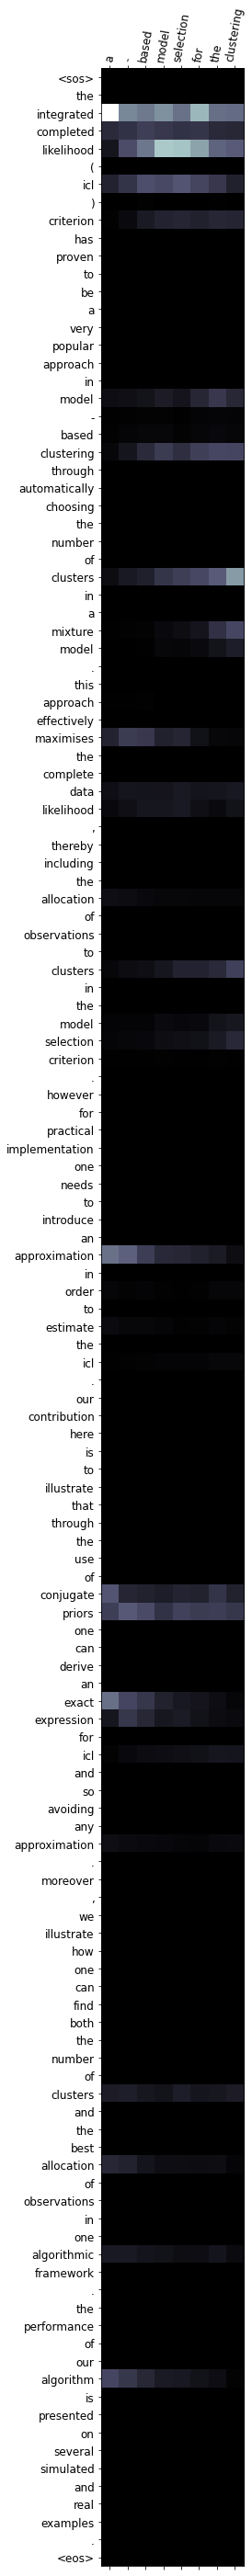

In [39]:
display_attention(src, translation, attention)

In [40]:
for example_idx in range(100):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(model, src, TEXT, device)

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  diversity and its decomposition into variety , balance and disparity
Предсказанный заголовок:  diversity diversity and diversity of diversity
-----------------------------------
Оригинальный заголовок:  improving the johnson - lindenstrauss lemma
Предсказанный заголовок:  on the distance of distance - distance
-----------------------------------
Оригинальный заголовок:  the mean - field approximation model of company 's income growth
Предсказанный заголовок:  a - law of income income income distribution
-----------------------------------
Оригинальный заголовок:  efficient inference of protein structural ensembles
Предсказанный заголовок:  protein - protein model for protein - protein
-----------------------------------
Оригинальный заголовок:  financial black swans driven by ultrafast machine ecology
Предсказанный заголовок:  the of of the - of the financial markets
-----------------------------------
Оригинальный заголовок:  tracking dynamic point processes o

In [41]:
example_idx = 0

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['suppose', 'a', 'string', '$', 'x_1^n=(x_1,x_2,', '...', ',x_n)$', 'generated', 'by', 'a', 'memoryless', 'source', '$', '(', 'x_n)_{n\\geq', '1}$', 'with', 'distribution', '$', 'p$', 'is', 'to', 'be', 'compressed', 'with', 'distortion', 'no', 'greater', 'than', '$', 'd\\geq', '0', '$', ',', 'using', 'a', 'memoryless', 'random', 'codebook', 'with', 'distribution', '$', 'q$.', 'the', 'compression', 'performance', 'is', 'determined', 'by', 'the', '`', '`', 'generalized', 'asymptotic', 'equipartition', 'property', "'", "'", '(', 'aep', ')', ',', 'which', 'states', 'that', 'the', 'probability', 'of', 'finding', 'a', '$', 'd$-close', 'match', 'between', '$', 'x_1^n$', 'and', 'any', 'given', 'codeword', '$', 'y_1^n$', ',', 'is', 'approximately', '$', '2^{-n', 'r(p', ',', 'q', ',', 'd)}$', ',', 'where', 'the', 'rate', 'function', '$', 'r(p', ',', 'q', ',', 'd)$', 'can', 'be', 'expressed', 'as', 'an', 'infimum', 'of', 'relative', 'entropies', '.', 'the', 'main', 'purpose', 'here', 'is', 

predicted trg = ['on', 'the', 'generalized', 'reversed', 'of', 'of', 'the', 'generalized', 'reversed']


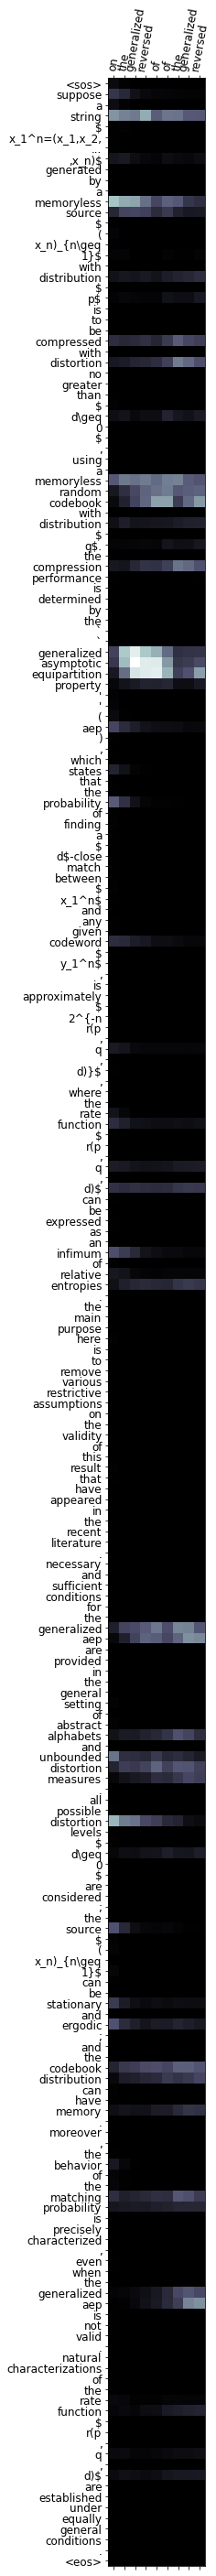

In [42]:
translation, attention = translate_sentence(model, src, TEXT, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [43]:
example_idx = 510

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'present', 'a', 'bayesian', 'hierarchical', 'framework', 'for', 'both', 'cross', '-', 'sectional', 'and', 'time', '-', 'series', 'return', 'prediction', '.', 'our', 'approach', 'builds', 'on', 'a', 'market', '-', 'timing', 'predictive', 'system', 'that', 'jointly', 'allows', 'for', 'time', '-', 'varying', 'coefficients', 'driven', 'by', 'fundamental', 'characteristics', '.', 'with', 'a', 'bayesian', 'formulation', 'for', 'ensemble', 'learning', ',', 'we', 'examine', 'the', 'joint', 'predictability', 'as', 'well', 'as', 'portfolio', 'efficiency', 'via', 'predictive', 'distribution', '.', 'in', 'the', 'empirical', 'analysis', 'of', 'asset', '-', 'sector', 'allocation', ',', 'our', 'hierarchical', 'ensemble', 'learning', 'portfolio', 'achieves', '500', '%', 'cumulative', 'returns', 'in', 'the', 'period', '1998', '-', '2017', ',', 'and', 'outperforms', 'most', 'workhorse', 'benchmarks', 'as', 'well', 'as', 'the', 'passive', 'investing', 'index', '.', 'our', 'bayesian', 'infere

predicted trg = ['bayesian', 'hierarchical', 'bayesian', 'portfolio', 'prediction']


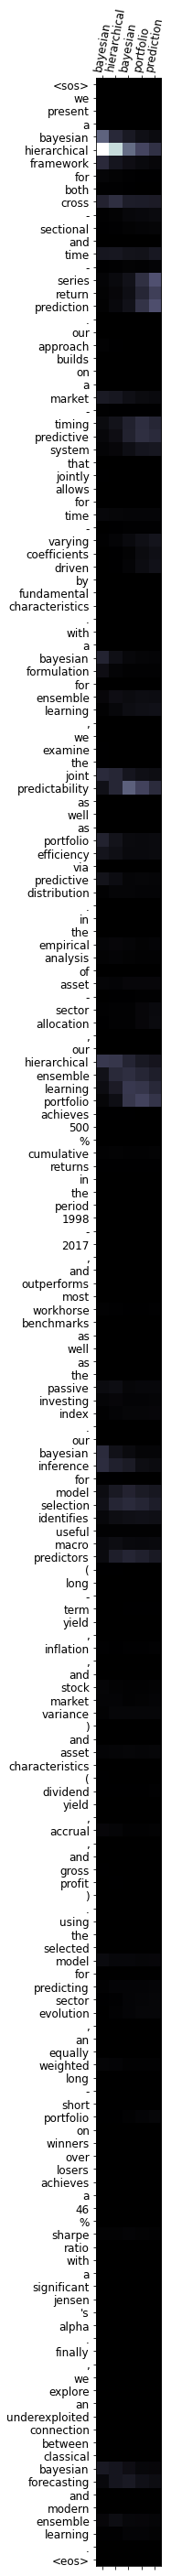

In [44]:
translation, attention = translate_sentence(model, src, TEXT, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### Считаем BLEU на train.csv

In [45]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]

In [46]:
test_len = len(test_data)

In [47]:
original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, _ = translate_sentence(model, src, TEXT, device)

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

In [48]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (LSTM): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (LSTM): 0.02474


### Делаем submission в Kaggle

In [49]:
import pandas as pd

submission_data = pd.read_csv('../../data/raw/title-generation/test.csv')
abstracts = submission_data['abstract'].values

Генерация заголовков для тестовых данных:

In [50]:
titles = []
for abstract in abstracts:
    title, _ = translate_sentence(model, abstract.split(), TEXT, device)
    titles.append(' '.join(title).replace('<unk>', ''))

Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [51]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

С помощью скрипта `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [52]:
generate_csv('predicted_titles.csv', 'kaggle_pred.csv', 'vocs.pkl')